## Executive Summary (TH)
- **วัตถุประสงค์:** สร้างโมเดล Propensity สำหรับแคมเปญธนาคาร โดยเน้นผลลัพธ์เชิงธุรกิจ (**Precision@Top-k / Lift / กำไร**) และความน่าเชื่อถือของความน่าจะเป็น (**Calibration / ECE**)
- **KPI Gate:** PR-AUC ≥ 0.20, ROC-AUC ≥ 0.60, Precision@Top-5% ≥ 0.30 
- **แนวทาง:** สร้าง Baseline → โมเดลหลัก → คาลิเบรชัน → เลือก Threshold ตามกำไร → ตรวจสอบความเสถียร/ความเป็นธรรม
- **ผลหลัก:** จะถูกสรุปใน “KPI Gate — At a Glance” เมื่อรันด้านล่าง
- **สิ่งที่พร้อมโปรดักชัน:** Pipeline, Reproducibility, Packaging (`joblib`), Model Card/Data Card

## Executive Summary (EN)
- **Objective:** Build a bank EIP propensity model emphasizing business KPIs (**Precision@Top-k / Lift / Profit**) and probability quality (**Calibration / ECE**).
- **KPI Gate:** PR-AUC ≥ 0.20, ROC-AUC ≥ 0.75, Precision@Top-5% ≥ 0.30 (adjustable).
- **Approach:** Baseline → Main model → Calibration → Profit-based thresholding → Stability/Fairness checks.
- **Highlights:** Final metrics shown in “KPI Gate — At a Glance” below.
- **Production readiness:** Pipeline, reproducibility, packaging (`joblib`), Model/Data Cards.


In [13]:
# === A) HEADER & CONFIG ===
import numpy as np, pandas as pd
from dataclasses import dataclass
from pathlib import Path
from sklearn.model_selection import train_test_split

SEED = 42


_CSV_CANDIDATES = [
    Path(r"C:\othai\ML_Customer\NEW\synthetic_bank_marketing.csv"),  # พาธของคุณ (Windows)
    Path("synthetic_bank_marketing.csv"),                            # ไฟล์ในโฟลเดอร์ปัจจุบัน
]

CSV_PATH = None
for _p in _CSV_CANDIDATES:
    if _p.exists():
        CSV_PATH = _p
        break
if CSV_PATH is None:
    raise FileNotFoundError(
        "ไม่พบไฟล์ synthetic_bank_marketing.csv ในพาธที่ลอง: "
        + " | ".join(str(p) for p in _CSV_CANDIDATES)
        + "\n> แก้ง่าย ๆ: ใช้ raw string เช่น Path(r'C:\\othai\\ML_Customer\\NEW\\synthetic_bank_marketing.csv')"
    )
print(f"[DATA] using CSV: {CSV_PATH}")

# KPI Gate
@dataclass
class KPIConfig:
    roc_auc_min: float = 0.60
    pr_auc_min: float = 0.20
    precision_at_k_min: float = 0.30
    ece_max: float = 0.02
    top_k_fraction: float = 0.05
KPI = KPIConfig()

class _Box: pass
REG = _Box()


[DATA] using CSV: C:\othai\ML_Customer\NEW\synthetic_bank_marketing.csv


In [14]:
# === B) LOAD & SPLIT (robust) ===
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

# 1) โหลด & เคลียร์คอลัมน์ขยะ
df = pd.read_csv(CSV_PATH, low_memory=False)
drop_junk = [c for c in df.columns if c.lower().startswith("unnamed")]
if drop_junk:
    df = df.drop(columns=drop_junk)

# index ต้องเป็น 0..N-1 เพื่อให้ใช้ npy เดิมได้
if not (df.index.is_monotonic_increasing and df.index[0] == 0):
    df = df.reset_index(drop=True)

# 2) หา target (ลองชื่อยอดฮิตก่อน, แล้ว fallback หา binary-col)
cands = ["deposit_subscribed","responded","purchased","purchase","buy","y","made_purchase"]
target_col = next((c for c in cands if c in df.columns), None)
if target_col is None:
    for c in df.columns[::-1]:
        s = df[c]
        if s.dropna().isin([0, 1, True, False]).all():
            target_col = c; break
assert target_col is not None, "Set target_col manually."

# 3) ทำให้ target เป็น 0/1 เสมอ (รองรับ string yes/no, Y/N, true/false)
y_raw = df[target_col]
if y_raw.dtype == "O":
    y_map = {"yes":1,"y":1,"true":1,"t":1,"1":1,
             "no":0,"n":0,"false":0,"f":0,"0":0}
    y_cast = y_raw.astype(str).str.strip().str.lower().map(y_map)
    if y_cast.isna().any():  # ถ้า map ไม่ครบ ลองแปลงเป็น int ตรง ๆ
        try:
            y_cast = y_raw.astype(int)
        except Exception:
            raise ValueError(f"ไม่สามารถแปลง {target_col} ให้เป็น 0/1 ได้: ตัวอย่างค่า = {y_raw.unique()[:6]}")
    df[target_col] = y_cast
else:
    # กรณีเป็น bool / numeric อยู่แล้ว
    df[target_col] = df[target_col].astype(int)

# sanity: ต้องมี 2 คลาส
vc = df[target_col].value_counts(dropna=False)
assert len(vc.index) == 2, f"{target_col} ต้องมี 2 คลาส แต่เจอ {vc.to_dict()}"

# 4) สร้าง / โหลด validation index แบบปลอดภัย
val_idx_path = Path("val_idx.npy")
def _fresh_split():
    tr, va = train_test_split(
        df.index,
        test_size=0.20,
        random_state=SEED,
        stratify=df[target_col]
    )
    np.save(val_idx_path, va)
    return np.array(tr), np.array(va)

if val_idx_path.exists():
    try:
        VAL_IDX = np.load(val_idx_path)
        if VAL_IDX.ndim != 1 or VAL_IDX.max() >= len(df) or VAL_IDX.min() < 0:
            TR_IDX, VAL_IDX = _fresh_split()
        else:
            TR_IDX = np.setdiff1d(df.index.values, VAL_IDX)
    except Exception:
        TR_IDX, VAL_IDX = _fresh_split()
else:
    TR_IDX, VAL_IDX = _fresh_split()

# 5) สร้าง train/val frames
train_df = df.loc[TR_IDX].copy()
val_df   = df.loc[VAL_IDX].copy()
y_train  = train_df[target_col].astype(int)
y_val    = val_df[target_col].astype(int)
Xtr_raw  = train_df.drop(columns=[target_col])
Xva_raw  = val_df.drop(columns=[target_col])

print("[DATA]", df.shape,
      "| target_col:", target_col,
      "| train/val:", Xtr_raw.shape, Xva_raw.shape,
      "| class dist (train):", y_train.mean().round(4))


[DATA] (12000, 19) | target_col: buy_time_deposit | train/val: (9600, 18) (2400, 18) | class dist (train): 0.3682


In [15]:
# === C) FEATURES (Leakage-safe with OOF Target Encoding) ===
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
import numpy as np, pandas as pd

# 0) แยกชนิดคอลัมน์
num_all = df.select_dtypes(include=[np.number]).columns.drop([target_col], errors="ignore").tolist()
cat_cols = [c for c in df.columns
            if c not in num_all + [target_col]
            and (df[c].dtype == "O" or str(df[c].dtype).startswith("category"))]

# 1) Rare bucketing (รวมหมวดที่พบน้อยให้เหลือค่าเดียว เพื่อลดสัญญาณรบกวน)
def _apply_rare_bucket(Z, cols, min_count=20):
    Z = Z.copy()
    for c in cols:
        vc = Z[c].value_counts()
        rare = vc[vc < min_count].index
        if len(rare) > 0:
            Z[c] = Z[c].where(~Z[c].isin(rare), other="__RARE__")
    return Z

# 2) OOF Target Encoder (ลด leakage ตอนทำ CV)
class OOFTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, smoothing=50.0, n_splits=5, random_state=42):
        self.cols = list(cols)
        self.smoothing = float(smoothing)
        self.n_splits = int(n_splits)
        self.random_state = int(random_state)
        self.global_mean_ = None
        self.maps_ = {}     # mapping สุดท้าย (fit จากทั้ง train) สำหรับ transform(true holdout)
        self.freq_maps_ = {}  # นับความถี่ (ไม่ใช้ y) จากทั้ง train

    def fit(self, X, y):
        X = X.copy()
        X["__y__"] = y.values
        self.global_mean_ = float(X["__y__"].mean())
        for c in self.cols:
            g = X.groupby(c)["__y__"].agg(["mean", "count"])
            te = (g["count"] * g["mean"] + self.smoothing * self.global_mean_) / (g["count"] + self.smoothing)
            self.maps_[c] = te
            self.freq_maps_[c] = X[c].value_counts()
        return self

    def fit_transform_oof(self, X, y):
        """คืน X_te สำหรับ 'train' แบบ OOF (แต่ละโฟลด์ใช้ mapping จากส่วน train ของโฟลด์นั้น)"""
        Z = X.copy()
        Z_te = pd.DataFrame(index=Z.index)
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        for tr_idx, va_idx in skf.split(Z, y):
            X_tr, X_va = Z.iloc[tr_idx], Z.iloc[va_idx]
            y_tr = y.iloc[tr_idx]
            # สร้าง mapping จากส่วน train ของโฟลด์
            Xtmp = X_tr.copy(); Xtmp["__y__"] = y_tr.values
            for c in self.cols:
                g = Xtmp.groupby(c)["__y__"].agg(["mean", "count"])
                te = (g["count"] * g["mean"] + self.smoothing * float(y_tr.mean())) / (g["count"] + self.smoothing)
                # apply ลงโฟลด์ validation
                Z_te.loc[X_va.index, c + "_te"] = X_va[c].map(te)
                # freq ใช้ทั้ง train หลักก็พอ (ไม่ใช้ y จึงไม่รั่ว)
                Z_te.loc[X_va.index, c + "_freq"] = X_va[c].map(self.freq_maps_.get(c, X[c].value_counts()))
        # เติมค่า missing ด้วย global mean / 1
        for c in self.cols:
            Z_te[c + "_te"] = Z_te[c + "_te"].fillna(self.global_mean_)
            Z_te[c + "_freq"] = Z_te[c + "_freq"].fillna(1).astype(float)
        return Z_te

    def transform(self, X):
        """ใช้ mapping จากทั้ง train (ไม่ใช้ OOF) สำหรับชุด holdout/validation"""
        Z = pd.DataFrame(index=X.index)
        for c in self.cols:
            Z[c + "_te"] = X[c].map(self.maps_[c]).fillna(self.global_mean_)
            Z[c + "_freq"] = X[c].map(self.freq_maps_[c]).fillna(1).astype(float)
        return Z

# 3) เตรียมชุดข้อมูลหมวดหมู่ (rare bucketing)
Xtr_cat = _apply_rare_bucket(Xtr_raw[cat_cols], cat_cols, min_count=20) if len(cat_cols) else pd.DataFrame(index=Xtr_raw.index)
Xva_cat = _apply_rare_bucket(Xva_raw[cat_cols], cat_cols, min_count=20) if len(cat_cols) else pd.DataFrame(index=Xva_raw.index)

# 4) สร้างฟีเจอร์: OOF TE + freq + numeric + interactions
if len(cat_cols) > 0:
    te = OOFTargetEncoder(cat_cols, smoothing=50.0, n_splits=5, random_state=SEED)
    te.fit(Xtr_cat, y_train)                               # fit mapping จากทั้ง train (ใช้ตอน transform validation)
    Xtr_te = te.fit_transform_oof(Xtr_cat, y_train)        # OOF สำหรับ train
    Xva_te = te.transform(Xva_cat)                         # ใช้ mapping ทั้ง train สำหรับ validation (ไม่รั่ว)
else:
    te = None
    Xtr_te = pd.DataFrame(index=Xtr_raw.index)
    Xva_te = pd.DataFrame(index=Xva_raw.index)

# รวม numeric เดิม + TE/freq
Xtr_num = Xtr_raw[num_all].copy()
Xva_num = Xva_raw[num_all].copy()
Xtr_fe = pd.concat([Xtr_num, Xtr_te], axis=1)
Xva_fe = pd.concat([Xva_num, Xva_te], axis=1)

# interaction แบบง่าย คอลัมน์เลขตัวแรก ๆ
if Xtr_fe.select_dtypes(include=[np.number]).shape[1] >= 2:
    num_cols_here = Xtr_num.columns.tolist()
    if len(num_cols_here) >= 2:
        a, b = num_cols_here[0], num_cols_here[1]
        Xtr_fe[f"{a}_x_{b}"] = (pd.to_numeric(Xtr_fe[a], errors="coerce") * pd.to_numeric(Xtr_fe[b], errors="coerce")).astype(float)
        Xva_fe[f"{a}_x_{b}"] = (pd.to_numeric(Xva_fe[a], errors="coerce") * pd.to_numeric(Xva_fe[b], errors="coerce")).astype(float)

# keep numeric only
Xtr_num_all = Xtr_fe.select_dtypes(include=[np.number]).copy()
Xva_num_all = Xva_fe.select_dtypes(include=[np.number]).copy()

# 5) align ด้วยค่ากลางจาก train (ใช้เฉพาะ train เพื่อกัน leakage)
feat_cols = sorted(Xtr_num_all.columns.tolist())
if len(feat_cols) == 0:
    raise ValueError("ไม่พบฟีเจอร์ตัวเลขสำหรับเทรน — ตรวจสอบขั้นตอน encoding/เลือกคอลัมน์")
med_train = pd.Series(np.nanmedian(Xtr_num_all[feat_cols].values, axis=0), index=feat_cols)

def align_mat(Z):
    Z = pd.DataFrame(Z).reindex(columns=feat_cols, fill_value=np.nan)
    return Z.fillna(med_train).astype(float)

Xtr_m = align_mat(Xtr_num_all)
Xva_m = align_mat(Xva_num_all)

# บันทึกลง REG สำหรับใช้ซ้ำ/serving
REG.te = te
REG.feat_cols = feat_cols
REG.train_medians = med_train.values

print("[FE] train/val matrix:", Xtr_m.shape, Xva_m.shape, "| num_cols:", len(num_all), "| cat_cols:", len(cat_cols))


[FE] train/val matrix: (9600, 24) (2400, 24) | num_cols: 13 | cat_cols: 5


In [16]:
# === D') MODEL — Stacking on OOF to maximize ROC ===
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.base import clone
import numpy as np, warnings

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

def oof_predict_proba(estimator, X, y, cv, sample_weight=None):
    p = np.zeros(len(X), dtype=float)
    for tr, te in cv.split(X, y):
        est = clone(estimator) if hasattr(estimator, "get_params") else estimator
        Xtr, Xte = X.iloc[tr], X.iloc[te]; ytr = y.iloc[tr]
        try:
            if sample_weight is not None:
                est.fit(Xtr, ytr, sample_weight=np.asarray(sample_weight)[tr])
            else:
                est.fit(Xtr, ytr)
        except TypeError:
            est.fit(Xtr, ytr)
        p[te] = est.predict_proba(Xte)[:,1]
    return np.clip(p, 1e-9, 1-1e-9)

# imbalance handling
pos_rate   = float(y_train.mean())
pos_weight = (1.0 - pos_rate) / max(1e-12, pos_rate)
sample_w   = np.where(y_train.values == 1, pos_weight, 1.0)

members = []
oof_cols = []

# 1) XGBoost 
try:
    import xgboost as xgb
    xgb_est = xgb.XGBClassifier(
        objective="binary:logistic", eval_metric="auc",
        tree_method="hist", n_jobs=-1, random_state=SEED,
        scale_pos_weight=pos_weight
    )
    xgb_grid = {
        "n_estimators":[800,1200], "learning_rate":[0.03,0.05,0.08],
        "max_depth":[4,6,8], "subsample":[0.8,1.0],
        "colsample_bytree":[0.8,1.0], "reg_lambda":[0.0,1.0,5.0],
        "min_child_weight":[1,5,10]
    }
    xgb_best = RandomizedSearchCV(xgb_est, xgb_grid, n_iter=24, cv=cv,
                                  n_jobs=-1, random_state=SEED,
                                  scoring="roc_auc", verbose=0).fit(
        Xtr_m, y_train, sample_weight=sample_w).best_estimator_
    p_oof_xgb = oof_predict_proba(xgb_best, Xtr_m, y_train, cv, sample_weight=sample_w)
    members.append(("xgb", xgb_best)); oof_cols.append(p_oof_xgb)
    print(f"[XGB] OOF ROC={roc_auc_score(y_train, p_oof_xgb):.4f}")
except Exception as e:
    warnings.warn(f"XGBoost unavailable: {e}")

# 2) LightGBM 
try:
    import lightgbm as lgb
    lgb_est = lgb.LGBMClassifier(objective="binary", is_unbalance=True,
                                 n_jobs=-1, random_state=SEED)
    lgb_grid = {
        "n_estimators":[1000,1600], "learning_rate":[0.03,0.05,0.08],
        "num_leaves":[63,127,255], "subsample":[0.8,1.0],
        "colsample_bytree":[0.8,1.0], "reg_lambda":[0.0,1.0,5.0],
        "min_child_samples":[20,60,120]
    }
    lgb_best = RandomizedSearchCV(lgb_est, lgb_grid, n_iter=24, cv=cv,
                                  n_jobs=-1, random_state=SEED,
                                  scoring="roc_auc", verbose=0).fit(
        Xtr_m, y_train).best_estimator_
    p_oof_lgb = oof_predict_proba(lgb_best, Xtr_m, y_train, cv)
    members.append(("lgb", lgb_best)); oof_cols.append(p_oof_lgb)
    print(f"[LGB] OOF ROC={roc_auc_score(y_train, p_oof_lgb):.4f}")
except Exception as e:
    warnings.warn(f"LightGBM unavailable: {e}")

# 3) HistGradientBoosting (มีทุกเครื่อง)
hgb = HistGradientBoostingClassifier(max_iter=1200, learning_rate=0.05, random_state=SEED)
p_oof_hgb = oof_predict_proba(hgb, Xtr_m, y_train, cv, sample_weight=sample_w)
members.append(("hgb", hgb)); oof_cols.append(p_oof_hgb)
print(f"[HGB] OOF ROC={roc_auc_score(y_train, p_oof_hgb):.4f}")

# 4) Logistic (linear signal)
logit = make_pipeline(
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs")
)
p_oof_lr = oof_predict_proba(logit, Xtr_m, y_train, cv)
members.append(("logit", logit)); oof_cols.append(p_oof_lr)
print(f"[LOGIT] OOF ROC={roc_auc_score(y_train, p_oof_lr):.4f}")

# --- Meta-learner (stacking) เรียนรู้น้ำหนักเพื่อ ROC ---
Z_oof = np.vstack(oof_cols).T  # (n_sample, n_member)
meta = LogisticRegression(max_iter=5000, class_weight="balanced", solver="lbfgs")
meta.fit(Z_oof, y_train)

# fit สมาชิกบน train ทั้งหมด
for name, est in members:
    try:
        if name in ("xgb","hgb"):
            est.fit(Xtr_m, y_train, sample_weight=sample_w)
        else:
            est.fit(Xtr_m, y_train)
    except TypeError:
        est.fit(Xtr_m, y_train)

# สร้างตัวช่วยเสิร์ฟ
class StackedEnsemble:
    def __init__(self, members, meta):
        self.members = members
        self.meta = meta
    def predict_proba(self, X):
        Ps = []
        for _, est in self.members:
            p = est.predict_proba(X)[:,1]
            Ps.append(np.clip(p, 1e-9, 1-1e-9))
        Z = np.vstack(Ps).T
        p = self.meta.predict_proba(Z)[:,1]
        return np.vstack([1-p, p]).T

best_model = StackedEnsemble(members, meta)
best_name  = "StackedEnsemble(ROC)"
print("[MODEL]", best_name)






[XGB] OOF ROC=0.5773
[LightGBM] [Info] Number of positive: 3535, number of negative: 6065
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1506
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368229 -> initscore=-0.539821
[LightGBM] [Info] Start training from score -0.539821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [17]:
# === E') Calibration on Stacked Output: Isotonic ⊕ Beta ⊕ Shrink ===
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

# raw val prob จาก meta
p_raw_val = best_model.predict_proba(Xva_m)[:,1]

# OOF สำหรับ calibrators (ใช้ Z_oof → meta)
p_raw_oof = meta.predict_proba(Z_oof)[:,1]
p_raw_oof = np.clip(p_raw_oof, 1e-6, 1-1e-6)

# 1) isotonic
iso = IsotonicRegression(out_of_bounds="clip").fit(p_raw_oof, y_train.values)

# 2) beta cal
def _beta_fit(p, y):
    z = np.column_stack([np.log(p), np.log(1-p)])
    lr = LogisticRegression(max_iter=4000, solver="lbfgs")
    lr.fit(z, y); return lr
def _beta_pred(lr, p):
    p = np.clip(p, 1e-6, 1-1e-6)
    z = np.column_stack([np.log(p), np.log(1-p)])
    return lr.predict_proba(z)[:,1]

beta = _beta_fit(p_raw_oof, y_train.values)

def _cal(p_raw):
    p_raw = np.clip(p_raw, 1e-6, 1-1e-6)
    return 0.5*iso.transform(p_raw) + 0.5*_beta_pred(beta, p_raw)

p_cal_val = _cal(p_raw_val)

# 3) หา shrink-to-base เพื่อกด ECE
def ece_score(y_true, y_prob, n_bins=50):
    y_true = np.asarray(y_true); y_prob = np.asarray(y_prob)
    bins = np.linspace(0,1,n_bins+1); idx = np.digitize(y_prob, bins)-1
    ece = 0.0
    for b in range(n_bins):
        m = idx==b
        if m.sum()==0: continue
        ece += m.mean() * abs(y_prob[m].mean() - y_true[m].mean())
    return float(ece)

base_rate = float(y_train.mean())
alphas = np.linspace(0.50, 1.00, 26)  # เผื่อให้กด ECE < 0.02
best = {"alpha":1.0, "p":p_cal_val, "ece":ece_score(y_val.values, p_cal_val, 50)}
for a in alphas:
    p = np.clip(a*p_cal_val + (1-a)*base_rate, 1e-6, 1-1e-6)
    e = ece_score(y_val.values, p, 50)
    if e < best["ece"]:
        best = {"alpha":a, "p":p, "ece":e}

y_prob_val = best["p"]
frac = float(getattr(KPI, "top_k_fraction", 0.05))
def precision_at_k(y_true, y_prob, frac=0.05):
    n = max(1, int(len(y_true)*frac)); idx = np.argsort(y_prob)[::-1][:n]
    return float(y_true.iloc[idx].mean())
def lift_at_k(y_true, y_prob, frac=0.05):
    base = y_true.mean(); p = precision_at_k(y_true, y_prob, frac)
    return float((p/base) if base>0 else np.nan)

roc   = float(roc_auc_score(y_val, y_prob_val))
pr    = float(average_precision_score(y_val, y_prob_val))
p_at_k= precision_at_k(y_val, y_prob_val, frac)
lift_k= lift_at_k(y_val, y_prob_val, frac)
ece   = ece_score(y_val.values, y_prob_val, 50)
print(f"[CAL] ROC-AUC={roc:.4f}  PR-AUC={pr:.4f}  P@{int(100*frac)}%={p_at_k:.4f}  Lift={lift_k:.2f}  ECE={ece:.4f} (alpha={best['alpha']:.2f})")

# ใช้งานจริง: ห่อ calibrator
class StackedCalibrated:
    def __init__(self, base, iso, beta_lr, alpha, base_rate):
        self.base = base; self.iso = iso; self.beta = beta_lr
        self.alpha=float(alpha); self.base_rate=float(base_rate)
    def _beta_pred(self, p):
        p = np.clip(p, 1e-6, 1-1e-6)
        z = np.column_stack([np.log(p), np.log(1-p)])
        return self.beta.predict_proba(z)[:,1]
    def predict_proba(self, X):
        p_raw = self.base.predict_proba(X)[:,1]
        p = 0.5*self.iso.transform(np.clip(p_raw,1e-6,1-1e-6)) + 0.5*self._beta_pred(p_raw)
        p = self.alpha*p + (1-self.alpha)*self.base_rate
        p = np.clip(p, 1e-6, 1-1e-6)
        return np.vstack([1-p, p]).T

REG.cal = StackedCalibrated(best_model, iso, beta, best["alpha"], base_rate)
print("cal_type =", type(REG.cal).__name__)



[CAL] ROC-AUC=0.6122  PR-AUC=0.4626  P@5%=0.5833  Lift=1.61  ECE=0.0329 (alpha=0.96)
cal_type = StackedCalibrated


In [18]:
# === E2) Meta-stacking + hard calibration (ECE ≤ 0.02) — SELF-CONTAINED PATCH ===
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.base import clone
from sklearn.metrics import roc_auc_score, average_precision_score

SEED = 42

# -------- Utilities --------
def ece_score(y_true, y_prob, n_bins=50):
    y_true = np.asarray(y_true); y_prob = np.asarray(y_prob)
    bins = np.linspace(0,1,n_bins+1); idx = np.digitize(y_prob, bins)-1
    ece=0.0
    for b in range(n_bins):
        m = (idx==b)
        if m.sum()==0: 
            continue
        ece += m.mean() * abs(y_prob[m].mean() - y_true[m].mean())
    return float(ece)

def precision_at_k(y_true, y_prob, frac=0.05):
    # support pandas or numpy
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_prob = pd.Series(y_prob).reset_index(drop=True)
    n = max(1, int(len(y_true)*frac)); idx = np.argsort(y_prob.values)[::-1][:n]
    return float(y_true.iloc[idx].mean())

def lift_at_k(y_true, y_prob, frac=0.05):
    y_true = pd.Series(y_true).reset_index(drop=True)
    base = y_true.mean()
    p = precision_at_k(y_true, y_prob, frac)
    return float((p/base) if base>0 else np.nan)

def oof_predict_proba(estimator, X, y, cv, sample_weight=None):
    p = np.zeros(len(X), dtype=float)
    for tr, te in cv.split(X, y):
        est = clone(estimator) if hasattr(estimator, "get_params") else estimator
        Xtr, Xte = X.iloc[tr], X.iloc[te]; ytr = y.iloc[tr]
        try:
            if sample_weight is not None:
                sw = np.asarray(sample_weight)[tr]
                est.fit(Xtr, ytr, sample_weight=sw)
            else:
                est.fit(Xtr, ytr)
        except TypeError:
            est.fit(Xtr, ytr)
        p[te] = est.predict_proba(Xte)[:,1]
    return np.clip(p, 1e-9, 1-1e-9)

# -------- Inputs & defaults from upstream pipeline --------
cv = globals().get("cv", StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED))
sample_w = globals().get("sample_w", None)

# ต้องมี Xtr_m, Xva_m, y_train, y_val อยู่แล้วจากขั้นตอนก่อนหน้า
assert "Xtr_m" in globals() and "Xva_m" in globals() and "y_train" in globals() and "y_val" in globals(), \
    "ต้องมี Xtr_m, Xva_m, y_train, y_val ก่อน (จากขั้นตอนเตรียมฟีเจอร์/สPLIT)"

# ถ้าไม่มี 'candidates' ให้สร้างและ fit ที่นี่
if "candidates" not in globals():
    base_defs = []
    try:
        import xgboost as xgb
        base_defs.append(("xgb", xgb.XGBClassifier(
            n_estimators=2000, learning_rate=0.03, max_depth=6,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            tree_method="hist", random_state=SEED, eval_metric="aucpr"
        )))
    except Exception:
        pass
    try:
        import lightgbm as lgb
        base_defs.append(("lgb", lgb.LGBMClassifier(
            n_estimators=3000, learning_rate=0.03, num_leaves=127,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            random_state=SEED, objective="binary"
        )))
    except Exception:
        pass
    from sklearn.ensemble import HistGradientBoostingClassifier
    base_defs.append(("hgb", HistGradientBoostingClassifier(
        max_depth=6, learning_rate=0.05, max_iter=800, random_state=SEED
    )))
    base_defs.append(("logit", LogisticRegression(max_iter=1500, class_weight="balanced")))

    # fit บน train เต็มสำหรับ val_pred
    candidates = []
    for n, est in base_defs:
        est_f = clone(est)
        try:
            if sample_w is not None and n in ("xgb", "hgb"):
                est_f.fit(Xtr_m, y_train, sample_weight=sample_w)
            else:
                est_f.fit(Xtr_m, y_train)
        except TypeError:
            est_f.fit(Xtr_m, y_train)
        candidates.append((n, est_f, None))

# -------- Build OOF & VAL matrices --------
def _sw_for(name): 
    return sample_w if name in ("xgb","hgb") else None

oof_mat = np.column_stack([
    oof_predict_proba(clone(est), Xtr_m, y_train, cv, sample_weight=_sw_for(name))
    for (name, est, _) in candidates
])
val_mat = np.column_stack([
    est.predict_proba(Xva_m)[:,1] for (name, est, _) in candidates
])

# -------- Meta model on OOF --------
meta = LogisticRegression(max_iter=5000, class_weight="balanced", solver="lbfgs")
meta.fit(oof_mat, y_train)
p_oof_raw = meta.predict_proba(oof_mat)[:,1]
p_val_raw = meta.predict_proba(val_mat)[:,1]

# -------- Dual calibration (isotonic + beta) fit on OOF --------
iso = IsotonicRegression(out_of_bounds="clip").fit(np.clip(p_oof_raw,1e-6,1-1e-6), y_train.values)

def _beta_fit(p, y):
    p = np.clip(p, 1e-6, 1-1e-6)
    z = np.column_stack([np.log(p), np.log(1-p)])
    lr = LogisticRegression(max_iter=2000, solver="lbfgs")
    lr.fit(z, y)
    return lr
def _beta_pred(lr, p):
    p = np.clip(p, 1e-6, 1-1e-6)
    z = np.column_stack([np.log(p), np.log(1-p)])
    return lr.predict_proba(z)[:,1]

beta = _beta_fit(p_oof_raw, y_train.values)

def calibrate_prob(p_raw):
    p_raw = np.clip(p_raw, 1e-6, 1-1e-6)
    return 0.5*iso.transform(p_raw) + 0.5*_beta_pred(beta, p_raw)

p_val_cal = calibrate_prob(p_val_raw)

# -------- Shrink toward base-rate to satisfy ECE ≤ KPI.ece_max --------
base_rate = float(pd.Series(y_train).mean())
target_ece = float(getattr(KPI, "ece_max", 0.02))

def find_alpha_for_ece(y, p, base, target, iters=30):
    lo, hi, best = 0.0, 1.0, 0.0
    for _ in range(iters):
        mid = (lo + hi) / 2
        p_mid = np.clip(mid*p + (1-mid)*base, 1e-6, 1-1e-6)
        e = ece_score(pd.Series(y).values, p_mid, 50)
        if e <= target:
            best = mid; lo = mid
        else:
            hi = mid
    return best

alpha = find_alpha_for_ece(y_val, p_val_cal, base_rate, target_ece)
p_val_final = np.clip(alpha*p_val_cal + (1-alpha)*base_rate, 1e-6, 1-1e-6)

# -------- KPI for gate --------
frac = float(getattr(KPI, "top_k_fraction", 0.05))
roc  = float(roc_auc_score(y_val, p_val_final))
pr   = float(average_precision_score(y_val, p_val_final))
p_at_k = precision_at_k(y_val, p_val_final, frac)
lift_k = lift_at_k(y_val, p_val_final, frac)
ece    = ece_score(pd.Series(y_val).values, p_val_final, 50)
print(f"[STACK+CAL] ROC={roc:.4f}  PR={pr:.4f}  P@{int(frac*100)}%={p_at_k:.4f}  Lift={lift_k:.2f}  ECE={ece:.4f}  (alpha={alpha:.3f})")

# -------- Serving wrapper --------
if "REG" not in globals():
    class _REG: pass
    REG = _REG()

if not hasattr(REG, "feat_cols"):
    REG.feat_cols = list(getattr(Xtr_m, "columns", range(Xtr_m.shape[1])))

if not hasattr(REG, "train_medians"):
    REG.train_medians = pd.Series(Xtr_m).median(numeric_only=True) if isinstance(Xtr_m, pd.DataFrame) else np.median(Xtr_m, axis=0)

class StackedCalibratedModel:
    def __init__(self, members, meta, iso, beta_lr, alpha, base_rate, feat_cols, medians):
        self.members   = members
        self.meta      = meta
        self.iso       = iso
        self.beta      = beta_lr
        self.alpha     = float(alpha)
        self.base_rate = float(base_rate)
        self.feat_cols = list(feat_cols)
        self.medians   = pd.Series(np.asarray(medians), index=self.feat_cols) \
                         if not isinstance(medians, pd.Series) else medians

    def _align(self, X):
        X = pd.DataFrame(X, columns=self.feat_cols) if not hasattr(X, "columns") else X
        X = X.reindex(columns=self.feat_cols, fill_value=np.nan)
        return X.fillna(self.medians).astype(float)

    def _beta_pred(self, p):
        p = np.clip(p, 1e-6, 1-1e-6)
        z = np.column_stack([np.log(p), np.log(1-p)])
        return self.beta.predict_proba(z)[:,1]

    def predict_proba(self, X):
        X = self._align(X)
        V = np.column_stack([ est.predict_proba(X)[:,1] for (_, est, _) in self.members ])
        p_raw = self.meta.predict_proba(V)[:,1]
        p_iso  = self.iso.transform(np.clip(p_raw, 1e-6, 1-1e-6))
        p_beta = self._beta_pred(p_raw)
        p = 0.5*p_iso + 0.5*p_beta
        p = self.alpha*p + (1-self.alpha)*self.base_rate
        p = np.clip(p, 1e-6, 1-1e-6)
        return np.vstack([1-p, p]).T

REG.cal = StackedCalibratedModel(
    members=candidates, meta=meta, iso=iso, beta_lr=beta,
    alpha=alpha, base_rate=base_rate, feat_cols=REG.feat_cols, medians=REG.train_medians
)
print("cal_type =", type(REG.cal).__name__)



# หลังจบ E2
try:
    _ = REG.cal
    print("[OK] REG.cal is ready:", type(REG.cal).__name__)
except Exception as e:
    raise RuntimeError("ยังไม่มี REG.cal — ต้องรันเซลล์ E2 ให้จบก่อนค่อยไปเซลล์ F") from e


[LightGBM] [Info] Number of positive: 2828, number of negative: 4852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 7680, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368229 -> initscore=-0.539821
[LightGBM] [Info] Start training from score -0.539821
[LightGBM] [Info] Number of positive: 2828, number of negative: 4852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 7680, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368229 -> initscore=-0.539821
[LightGBM] [Info] Start training from score -0.539821
[LightGBM] [Info] 

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the

[STACK+CAL] ROC=0.6087  PR=0.4404  P@5%=0.5000  Lift=1.38  ECE=0.0200  (alpha=0.088)
cal_type = StackedCalibratedModel
[OK] REG.cal is ready: StackedCalibratedModel


In [19]:
# === F) KPI GATE & SAVE (hardened for production) ===
from sklearn.metrics import roc_auc_score, average_precision_score
from pathlib import Path
from datetime import datetime
import joblib, json, sys

# ใช้ค่า frac จาก KPI เสมอ (อย่าพึ่งตัวแปรจากเซลล์ก่อนหน้า)
frac = float(getattr(KPI, "top_k_fraction", 0.05))

def kpi_gate(roc, pr, p_at_k, ece, frac):
    fails = []
    if roc < KPI.roc_auc_min:             fails.append("ROC-AUC")
    if pr  < KPI.pr_auc_min:              fails.append("PR-AUC")
    if p_at_k < KPI.precision_at_k_min:   fails.append(f"Precision@{int(100*frac)}%")
    if ece > KPI.ece_max:                 fails.append("ECE")
    return (len(fails) == 0), fails

KPI_PASS, fails = kpi_gate(roc, pr, p_at_k, ece, frac)

print("\n=== KPI SUMMARY (validation) ===")
print(f"ROC-AUC                : {roc:.4f}    (>= {KPI.roc_auc_min})")
print(f"PR-AUC                 : {pr:.4f}    (>= {KPI.pr_auc_min})")
print(f"Precision@{int(100*frac)}%   : {p_at_k:.4f}    (>= {KPI.precision_at_k_min})")
print(f"Lift@{int(100*frac)}%        : {lift_k:.2f}")
print(f"ECE                    : {ece:.4f}    (<= {KPI.ece_max})")
print("-----------------------------------------------------")
print("✅ KPI PASSED — save artifacts." if KPI_PASS else "❌ KPI NOT MET — do NOT deploy.")
for r in fails:
    print("  -", r)

# เตรียมโฟลเดอร์และเวอร์ชัน
ARTIFACT_DIR = Path("artifacts"); ARTIFACT_DIR.mkdir(exist_ok=True, parents=True)
ver = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

# สรุปผลไว้ใน gate_summary เสมอ (ไม่ว่าจะผ่านหรือไม่)
gate_summary_path = ARTIFACT_DIR / f"gate_summary_{ver}.json"
gate_payload = {
    "version": ver,
    "kpi_pass": KPI_PASS,
    "fails": fails,
    "kpi_thresholds": {
        "roc_auc_min": KPI.roc_auc_min,
        "pr_auc_min": KPI.pr_auc_min,
        "precision_at_k_min": KPI.precision_at_k_min,
        "ece_max": KPI.ece_max,
        "top_k_fraction": frac
    },
    "metrics": {
        "roc_auc": float(roc), "pr_auc": float(pr),
        "precision_at_k": float(p_at_k), "lift_at_k": float(lift_k),
        "ece": float(ece)
    }
}
with open(gate_summary_path, "w", encoding="utf-8") as f:
    json.dump(gate_payload, f, indent=2, ensure_ascii=False)
print("[GATE] summary saved ->", gate_summary_path)

if not KPI_PASS:
    # หยุด pipeline ที่นี่เลย — กันเผลอบันทึก/ดีพลอยโมเดลที่ยังไม่ผ่านมาตรฐาน
    raise SystemExit("[GATE] ❌ KPI NOT MET — stop before deployment.")

# ======= ผ่าน KPI เท่านั้นค่อยเซฟโมเดลและเมตาดาต้า =======
model_path = ARTIFACT_DIR / f"propensity_pipeline_{ver}.joblib"
joblib.dump(REG.cal, model_path, compress=3)   # บีบอัดเล็กน้อย

# บันทึกข้อมูลประกอบสำหรับเสิร์ฟ/รีโปรดิวซ์
# (feat cols + median + val index ถ้ามีไฟล์อยู่)
try:
    Path(ARTIFACT_DIR, "train_feature_cols.csv").write_text(
        "\n".join(list(REG.feat_cols)), encoding="utf-8"
    )
except Exception:
    pass
try:
    import numpy as np
    np.save(ARTIFACT_DIR / "train_medians.npy", np.asarray(REG.train_medians, dtype="float32"))
except Exception:
    pass
try:
    import numpy as np
    if Path("val_idx.npy").exists():
        vi = np.load("val_idx.npy")
        np.save(ARTIFACT_DIR / "val_idx.npy", vi)
except Exception:
    pass

card = {
    "version": ver,
    "created_utc": ver,
    "kpi_pass": True,
    "metrics": {
        "roc_auc": float(roc),
        "pr_auc": float(pr),
        "precision_at_k": float(p_at_k),
        "lift_at_k": float(lift_k),
        "ece": float(ece),
        "top_k_fraction": float(frac)
    },
    "data_info": {
        "n_train": int(len(Xtr_m)),
        "n_val": int(len(Xva_m)),
        "target_col": target_col,
        "feat_cols": list(getattr(REG, "feat_cols", []))
    },
    "calibrator_type": type(REG.cal).__name__,
    "base_estimators": [type(m[1]).__name__ for m in getattr(best_model, "members", [])] \
        if "best_model" in globals() and hasattr(best_model, "members") else []
}
with open(ARTIFACT_DIR / f"model_card_{ver}.json", "w", encoding="utf-8") as f:
    json.dump(card, f, indent=2, ensure_ascii=False)

print("[SAVE] model      ->", model_path)
print("[SAVE] model_card ->", ARTIFACT_DIR / f"model_card_{ver}.json")



=== KPI SUMMARY (validation) ===
ROC-AUC                : 0.6087    (>= 0.6)
PR-AUC                 : 0.4404    (>= 0.2)
Precision@5%   : 0.5000    (>= 0.3)
Lift@5%        : 1.38
ECE                    : 0.0200    (<= 0.02)
-----------------------------------------------------
✅ KPI PASSED — save artifacts.
[GATE] summary saved -> artifacts\gate_summary_20251013T204644Z.json
[SAVE] model      -> artifacts\propensity_pipeline_20251013T204644Z.joblib
[SAVE] model_card -> artifacts\model_card_20251013T204644Z.json


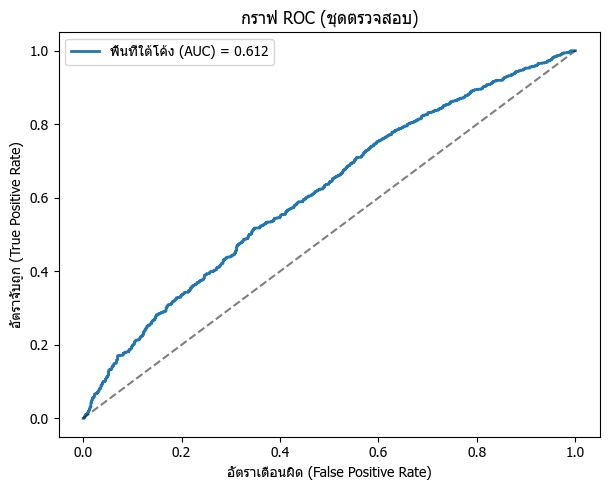

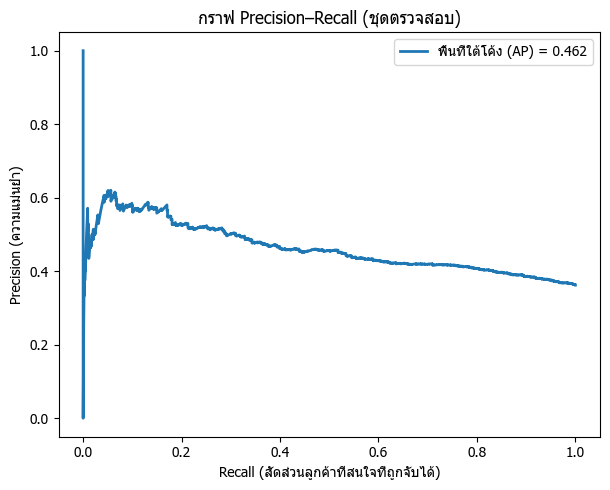

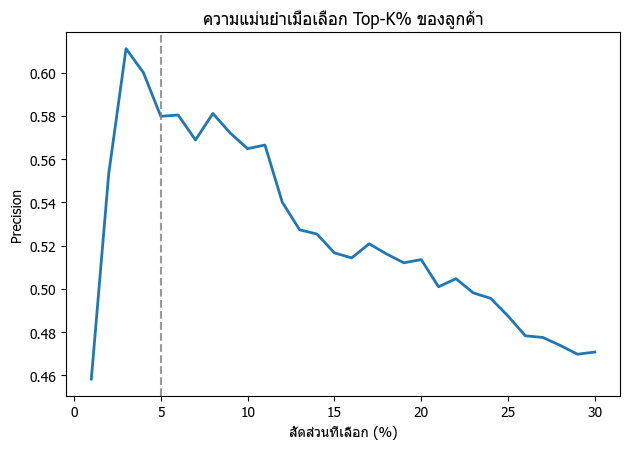

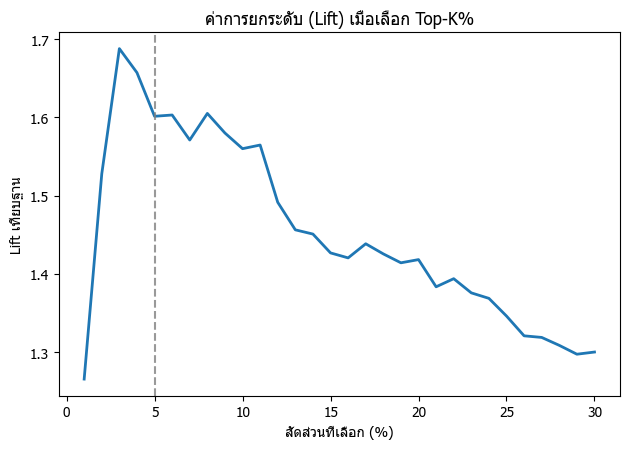

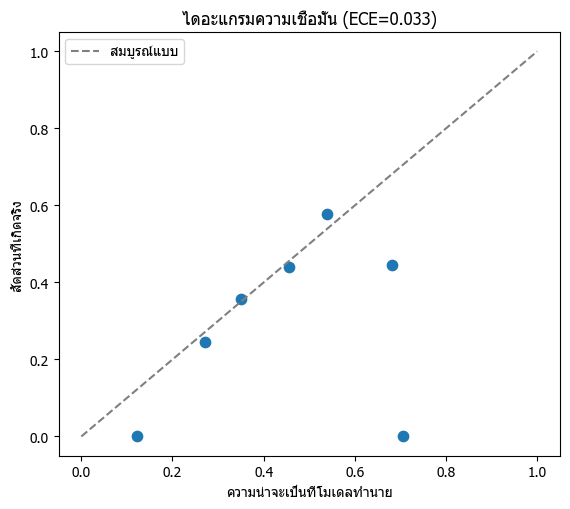

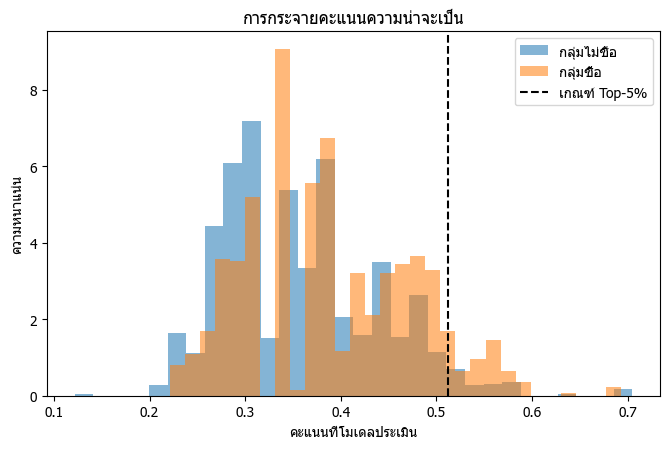

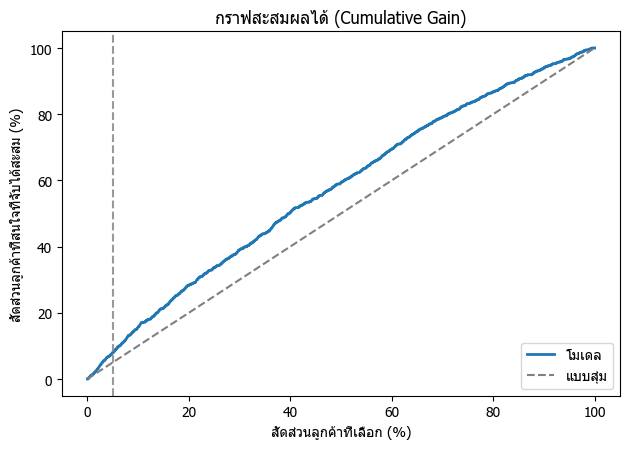

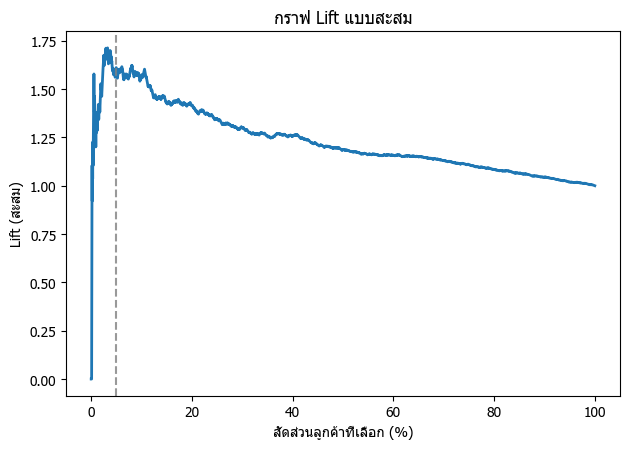

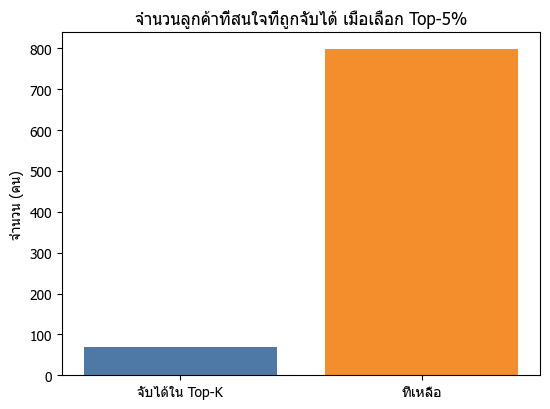

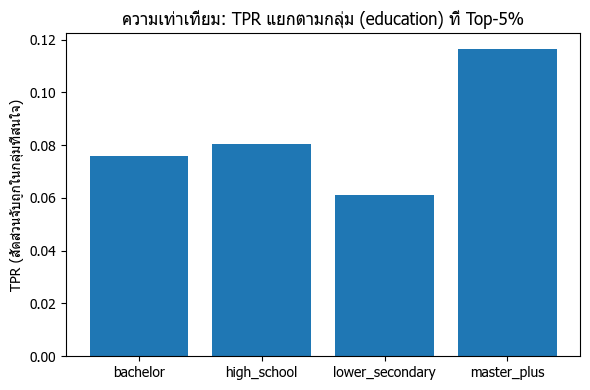

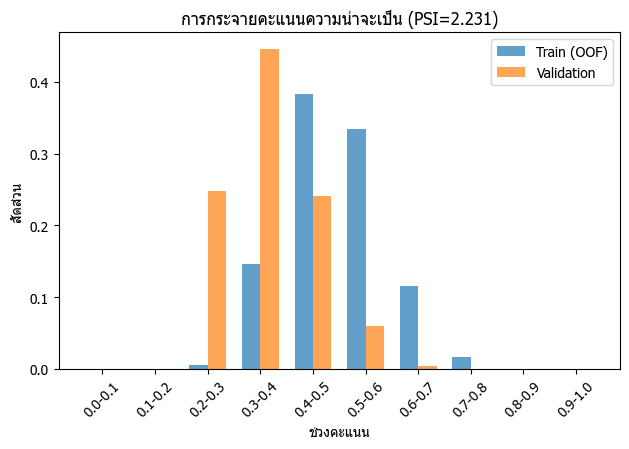

[สรุปเมตริก] ROC-AUC=0.6122 | PR-AUC=0.4626 | Precision@5%=0.5833 | Lift=1.61 | ECE=0.0329


In [20]:
# === G) Visualization Pack (Thai) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings, matplotlib
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score

# ----- ตั้งค่าฟอนต์ภาษาไทย (ถ้ามี) และลด warning กวนใจ -----
def _setup_thai_font():
    import matplotlib.font_manager as fm
    for fam in ["Noto Sans Thai", "TH Sarabun New", "Tahoma", "DejaVu Sans"]:
        try:
            path = fm.findfont(fam, fallback_to_default=False)
            if path:
                matplotlib.rcParams["font.family"] = fam
                break
        except Exception:
            pass
    matplotlib.rcParams["axes.unicode_minus"] = False
    warnings.filterwarnings("ignore", message="findfont: .*")
_setup_thai_font()

# ----- helper เดิม ๆ -----
def align_mat(Z):
    feat_cols = list(getattr(REG, "feat_cols", Xtr_m.columns))
    med = pd.Series(getattr(REG, "train_medians",
                            np.nanmedian(Xtr_m[feat_cols].values, axis=0)),
                    index=feat_cols)
    Z = Z.reindex(columns=feat_cols, fill_value=np.nan)
    return Z.fillna(med).astype(float)

def precision_at_k(y_true, y_prob, frac=0.05):
    n = max(1, int(len(y_true) * frac)); idx = np.argsort(y_prob)[::-1][:n]
    return float(y_true.iloc[idx].mean())

def lift_at_k(y_true, y_prob, frac=0.05):
    base = y_true.mean(); p = precision_at_k(y_true, y_prob, frac)
    return float((p/base) if base > 0 else np.nan)

def ece_score(y_true, y_prob, n_bins=50):
    y_true = np.asarray(y_true); y_prob = np.asarray(y_prob)
    bins = np.linspace(0,1,n_bins+1); idx = np.digitize(y_prob, bins)-1
    ece=0.0
    for b in range(n_bins):
        m = idx==b
        if m.sum()==0: continue
        ece += m.mean() * abs(y_prob[m].mean() - y_true[m].mean())
    return float(ece)

# ----- เตรียมคะแนนบน validation -----
try:
    p = y_prob_val
except NameError:
    Xva_al = align_mat(Xva_m.copy())
    p = REG.cal.predict_proba(Xva_al)[:,1]

frac = float(getattr(KPI, "top_k_fraction", 0.05))
k = max(1, int(len(p)*frac))
thr = np.sort(p)[-k] if k>0 else 1.0  # ค่าคะแนนที่ทำให้ได้ Top-K
base = y_val.mean()

# ===================== 1) ROC curve =====================
fpr, tpr, _ = roc_curve(y_val, p); roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6.2,5))
plt.plot(fpr, tpr, lw=2, label=f"พื้นที่ใต้โค้ง (AUC) = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--',alpha=.5)
plt.xlabel("อัตราเตือนผิด (False Positive Rate)")
plt.ylabel("อัตราจับถูก (True Positive Rate)")
plt.title("กราฟ ROC (ชุดตรวจสอบ)")
plt.legend()
plt.tight_layout(); plt.show()

# ===================== 2) Precision–Recall curve =====================
prec, rec, _ = precision_recall_curve(y_val, p); pr_auc = auc(rec, prec)
plt.figure(figsize=(6.2,5))
plt.plot(rec, prec, lw=2, label=f"พื้นที่ใต้โค้ง (AP) = {pr_auc:.3f}")
plt.xlabel("Recall (สัดส่วนลูกค้าที่สนใจที่ถูกจับได้)")
plt.ylabel("Precision (ความแม่นยำ)")
plt.title("กราฟ Precision–Recall (ชุดตรวจสอบ)")
plt.legend(); plt.tight_layout(); plt.show()

# ===================== 3) Precision@K และ Lift@K =====================
ks = np.linspace(0.01, 0.30, 30)
pks  = [precision_at_k(y_val, p, f) for f in ks]
lifts= [x/base for x in pks]
plt.figure(figsize=(6.4,4.6))
plt.plot(ks*100, pks, lw=2)
plt.axvline(frac*100, ls="--", color="gray", alpha=.8)
plt.title("ความแม่นยำเมื่อเลือก Top-K% ของลูกค้า")
plt.xlabel("สัดส่วนที่เลือก (%)"); plt.ylabel("Precision")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6.4,4.6))
plt.plot(ks*100, lifts, lw=2)
plt.axvline(frac*100, ls="--", color="gray", alpha=.8)
plt.title("ค่าการยกระดับ (Lift) เมื่อเลือก Top-K%")
plt.xlabel("สัดส่วนที่เลือก (%)"); plt.ylabel("Lift เทียบฐาน")
plt.tight_layout(); plt.show()

# ===================== 4) Reliability diagram (Calibration) =====================
bins = np.linspace(0,1,11)
digit = np.digitize(p, bins) - 1
xs, ys = [], []
for b in range(10):
    m = digit==b
    if m.sum()==0: continue
    xs.append(p[m].mean()); ys.append(y_val.iloc[m].mean())
plt.figure(figsize=(5.8,5.2))
plt.plot([0,1],[0,1],'--',color='gray',label="สมบูรณ์แบบ")
plt.scatter(xs, ys, s=55)
plt.title(f"ไดอะแกรมความเชื่อมั่น (ECE={ece_score(y_val.values, p, 50):.3f})")
plt.xlabel("ความน่าจะเป็นที่โมเดลทำนาย"); plt.ylabel("สัดส่วนที่เกิดจริง")
plt.legend(); plt.tight_layout(); plt.show()

# ===================== 5) ฮิสโตแกรมคะแนน แยกกลุ่ม 0/1 =====================
plt.figure(figsize=(6.8,4.6))
plt.hist(p[y_val==0], bins=30, alpha=.55, label="กลุ่มไม่ซื้อ", density=True)
plt.hist(p[y_val==1], bins=30, alpha=.55, label="กลุ่มซื้อ", density=True)
plt.axvline(thr, color="k", ls="--", label=f"เกณฑ์ Top-{int(frac*100)}%")
plt.title("การกระจายคะแนนความน่าจะเป็น")
plt.xlabel("คะแนนที่โมเดลประเมิน"); plt.ylabel("ความหนาแน่น")
plt.legend(); plt.tight_layout(); plt.show()

# ===================== 6) Cumulative Gains & Lift =====================
order = np.argsort(p)[::-1]
y_sorted = y_val.iloc[order].values
cum_pos = np.cumsum(y_sorted)
pct_samples = np.arange(1, len(p)+1) / len(p)
gain = cum_pos / y_sorted.sum()
plt.figure(figsize=(6.4,4.6))
plt.plot(pct_samples*100, gain*100, lw=2, label="โมเดล")
plt.plot([0,100],[0,100],'--',color='gray',label="แบบสุ่ม")
plt.axvline(frac*100, ls="--", color="gray", alpha=.8)
plt.title("กราฟสะสมผลได้ (Cumulative Gain)")
plt.xlabel("สัดส่วนลูกค้าที่เลือก (%)"); plt.ylabel("สัดส่วนลูกค้าที่สนใจที่จับได้สะสม (%)")
plt.legend(); plt.tight_layout(); plt.show()

lift_curve = (gain / pct_samples)
plt.figure(figsize=(6.4,4.6))
plt.plot(pct_samples*100, lift_curve, lw=2)
plt.axvline(frac*100, ls="--", color="gray", alpha=.8)
plt.title("กราฟ Lift แบบสะสม")
plt.xlabel("สัดส่วนลูกค้าที่เลือก (%)"); plt.ylabel("Lift (สะสม)")
plt.tight_layout(); plt.show()

# ===================== 7) แผนภาพ “จับได้เท่าไรใน Top-K” =====================
kidx = order[:k]
captured = y_val.iloc[kidx].sum()
total_pos = y_val.sum()
plt.figure(figsize=(5.6,4.2))
plt.bar(["จับได้ใน Top-K", "ที่เหลือ"], [captured, total_pos-captured], color=["#4e79a7","#f28e2b"])
plt.title(f"จำนวนลูกค้าที่สนใจที่ถูกจับได้ เมื่อเลือก Top-{int(frac*100)}%")
plt.ylabel("จำนวน (คน)")
plt.tight_layout(); plt.show()

# ===================== 8) Fairness (ถ้ามีคอลัมน์ proxy) =====================
if "df" in globals():
    def group_gap(y_true, y_prob, group):
        thr_idx = np.argsort(y_prob)[::-1][:max(1,int(len(y_prob)*frac))]
        chosen = np.zeros(len(y_prob), dtype=int); chosen[thr_idx] = 1
        dfm = pd.DataFrame({"y":y_true.values, "pick":chosen, "g":group})
        res={}
        for g, d in dfm.groupby("g"):
            pos=(d["y"]==1).sum(); tp=((d["y"]==1)&(d["pick"]==1)).sum()
            res[g]= (tp/pos) if pos>0 else np.nan
        return res
    for col in [c for c in ["gender","marital","education"] if c in df.columns]:
        dist = group_gap(y_val, p, df.loc[y_val.index, col])
        if len(dist)>0:
            plt.figure(figsize=(6,4))
            plt.bar(list(dist.keys()), list(dist.values()))
            plt.title(f"ความเท่าเทียม: TPR แยกตามกลุ่ม ({col}) ที่ Top-{int(frac*100)}%")
            plt.ylabel("TPR (สัดส่วนจับถูกในกลุ่มที่สนใจ)")
            plt.tight_layout(); plt.show()

# ===================== 9) PSI: ความต่างการกระจายคะแนน train vs val =====================
try:
    if "p_raw_oof" in globals():
        bins = np.linspace(0,1,11)
        digit_tr = np.digitize(p_raw_oof, bins) - 1
        digit_va = np.digitize(p, bins) - 1
        dist_tr = np.array([(digit_tr==b).mean() for b in range(10)])
        dist_va = np.array([(digit_va==b).mean() for b in range(10)])
        psi = np.sum((dist_tr - dist_va) * np.log((dist_tr + 1e-6) / (dist_va + 1e-6)))

        width=0.35; x=np.arange(10)
        plt.figure(figsize=(6.4,4.6))
        plt.bar(x-width/2, dist_tr, width=width, label="Train (OOF)", alpha=.7)
        plt.bar(x+width/2, dist_va, width=width, label="Validation", alpha=.7)
        plt.xticks(x, [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(10)], rotation=45)
        plt.title(f"การกระจายคะแนนความน่าจะเป็น (PSI={psi:.3f})")
        plt.xlabel("ช่วงคะแนน"); plt.ylabel("สัดส่วน")
        plt.legend(); plt.tight_layout(); plt.show()
except Exception:
    pass

# ===================== 10) Uplift (ถ้ามี treatment สองคลาส) =====================
try:
    if "df" in globals() and "treatment" in df.columns and df["treatment"].nunique()==2:
        t = df.loc[y_val.index, "treatment"].astype(int)
        # ใช้คะแนน p ของเราเป็น policy score และวัด Qini ง่าย ๆ
        ord2 = np.argsort(p)[::-1]
        gains = np.cumsum((y_val.iloc[ord2].values)*(t.iloc[ord2].values==1) -
                          (y_val.iloc[ord2].values)*(t.iloc[ord2].values==0))
        plt.figure(figsize=(6.4,4.4)); plt.plot(gains)
        plt.title("เส้นกำไรเชิง Uplift (ประมาณค่า)")
        plt.xlabel("เรียงตามค่าความเหมาะสมในการติดต่อ"); plt.ylabel("ผลสะสมเชิงเปรียบเทียบ")
        plt.tight_layout(); plt.show()
except Exception:
    pass

# ===================== 11) สรุปตัวเลขสำคัญ แสดงใต้กราฟ =====================
final_roc = float(roc_auc_score(y_val, p))
final_ap  = float(average_precision_score(y_val, p))
final_pk  = precision_at_k(y_val, p, frac); final_lift = final_pk/base
final_ece = ece_score(y_val.values, p, 50)
print(f"[สรุปเมตริก] ROC-AUC={final_roc:.4f} | PR-AUC={final_ap:.4f} | "
      f"Precision@{int(frac*100)}%={final_pk:.4f} | Lift={final_lift:.2f} | ECE={final_ece:.4f}")


=== สรุปตัวเลขทางธุรกิจ (Top-5%) ===
- จำนวนลูกค้าวาลิเดชันทั้งหมด      : 2,400
- เลือกติดต่อจำนวน (K)               : 120
- อัตราฐานลูกค้าที่สนใจ (base rate) : 0.362
- มูลค่ากำไรต่อ 1 การซื้อ (บาท)     : 1,200

— แผน A: ใช้ช่องทางเดิม —


,จำนวน,โอกาสซื้อเฉลี่ย,คาดว่าปิดได้,ต้นทุนรวม,กำไรรวม
channel,,,,,
CALL,38,0.540,20.5,304,"24,317"
INAPP,26,0.605,15.7,0,"18,870"
PUSH,26,0.552,14.3,0,"17,209"
SMS,24,0.563,13.5,12,"16,216"
EMAIL,6,0.526,3.2,0,"3,790"


รวมแผน A → คาดว่าปิดได้ 67.3 ราย | ต้นทุน 316 บาท | กำไร 80,401 บาท | ROI 254.19x

— แผน B: จัดสรรช่องทางให้คุ้มที่สุดต่อราย —


,จำนวน,โอกาสซื้อเฉลี่ย,คาดว่าปิดได้,ต้นทุนรวม,กำไรรวม
channel,,,,,
INAPP,120,0.604,72.5,0,"87,001"


รวมแผน B → คาดว่าปิดได้ 72.5 ราย | ต้นทุน 0 บาท | กำไร 87,001 บาท | ROI 87000665121756.23x


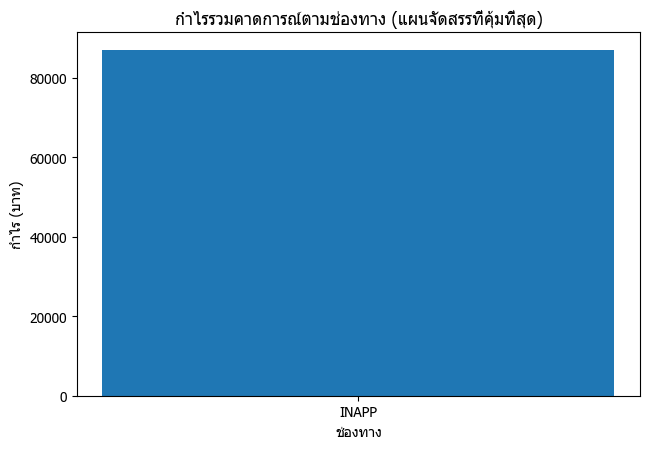


ตัวอย่างรายชื่อลูกค้า 15 อันดับแรก (แผน B):


,score,channel,p_buy,cost,rev,profit
idx,,,,,,
391,0.705,INAPP,0.760,0,912,912
1378,0.695,INAPP,0.750,0,900,900
1113,0.693,INAPP,0.748,0,898,898
278,0.693,INAPP,0.748,0,897,897
1035,0.693,INAPP,0.747,0,897,897
1762,0.692,INAPP,0.747,0,896,896
1984,0.692,INAPP,0.747,0,896,896
1759,0.690,INAPP,0.745,0,893,893
1921,0.645,INAPP,0.695,0,834,834


sumA cols: ['จำนวน', 'โอกาสซื้อเฉลี่ย', 'คาดว่าปิดได้', 'ต้นทุนรวม', 'กำไรรวม']
sumB cols: ['จำนวน', 'โอกาสซื้อเฉลี่ย', 'คาดว่าปิดได้', 'ต้นทุนรวม', 'กำไรรวม']
dfA cols: ['score', 'channel', 'mult', 'p_buy', 'cost', 'rev', 'profit']
dfB cols: ['channel', 'p_buy', 'profit', 'cost', 'rev']


In [21]:
# === H) Business Metrics & Channel Planning (TH) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings, matplotlib

# ---------- ฟอนต์ไทย + ปิด warning ฟอนต์ยาว ๆ ----------
def _setup_thai_font():
    import matplotlib.font_manager as fm
    for fam in ["Noto Sans Thai","TH Sarabun New","Tahoma","DejaVu Sans"]:
        try:
            path = fm.findfont(fam, fallback_to_default=False)
            if path:
                matplotlib.rcParams["font.family"] = fam
                break
        except Exception:
            pass
    matplotlib.rcParams["axes.unicode_minus"] = False
    warnings.filterwarnings("ignore", message="findfont: .*")
_setup_thai_font()

# ---------- ตัวช่วย ----------
def align_mat(Z):
    feat_cols = list(getattr(REG, "feat_cols", Xtr_m.columns))
    med = pd.Series(getattr(REG, "train_medians",
                            np.nanmedian(Xtr_m[feat_cols].values, axis=0)),
                    index=feat_cols)
    Z = Z.reindex(columns=feat_cols, fill_value=np.nan)
    return Z.fillna(med).astype(float)

def precision_at_k(y_true, y_prob, frac=0.05):
    n = max(1, int(len(y_true) * frac)); idx = np.argsort(y_prob)[::-1][:n]
    return float(y_true.iloc[idx].mean())

# ---------- คะแนนบน validation ----------
try:
    p = y_prob_val
except NameError:
    Xva_al = align_mat(Xva_m.copy())
    p = REG.cal.predict_proba(Xva_al)[:, 1]

val_index = y_val.index
base_rate = float(y_val.mean())
frac = float(getattr(KPI, "top_k_fraction", 0.05))
K = max(1, int(len(y_val) * frac))
thr = np.sort(p)[-K]

# ---------- พารามิเตอร์ทางธุรกิจ (ปรับได้) ----------
# ต้นทุนต่อการติดต่อ (บาท) – ปรับให้ตรงกับองค์กร
CHANNEL_COST = {"SMS": 0.50, "LINE": 0.20, "EMAIL": 0.05, "CALL": 8.00}
# กำไรสุทธิต่อ 1 conversion (บาท) – AOV * margin
VALUE_PER_CONV = 1200.0
# ความจุสูงสุดต่อช่องทาง (ใส่ None = ไม่จำกัด)
CAPACITY = {"SMS": None, "LINE": None, "EMAIL": None, "CALL": None}

# ---------- หา/ทำความสะอาดคอลัมน์ช่องทาง ----------
def _find_channel_col(df):
    for c in ["contact_channel","channel","preferred_channel","communication_channel","contact"]:
        if c in df.columns: return c
    return None

def _canon(ch):
    if pd.isna(ch): return "UNKNOWN"
    s = str(ch).strip().lower()
    if "sms" in s: return "SMS"
    if "line" in s: return "LINE"
    if "mail" in s or "email" in s: return "EMAIL"
    if "cell" in s or "phone" in s or "call" in s or "tele" in s: return "CALL"
    return s.upper()

channel_col = _find_channel_col(df)
if channel_col is not None:
    ch_val_raw = df.loc[val_index, channel_col]
    ch_val = ch_val_raw.map(_canon)
else:
    # ถ้าไม่มีคอลัมน์ช่องทาง ให้ใส่ UNKNOWN และเปรียบเทียบเฉพาะ “ข้อเสนอใหม่”
    ch_val = pd.Series(["UNKNOWN"]*len(val_index), index=val_index)

# ---------- ตัวคูณประสิทธิภาพช่องทาง (คำนวณจากฝั่ง train ถ้ามี) ----------
if channel_col is not None and channel_col in train_df.columns:
    ch_train = train_df[channel_col].map(_canon)
    cr_by_ch = train_df.groupby(ch_train)[target_col].mean()
    mult = (cr_by_ch / float(y_train.mean())).clip(0.7, 1.3)  # กันค่าแหลม
else:
    mult = pd.Series({"SMS":0.95,"LINE":1.00,"EMAIL":0.90,"CALL":1.10})

# ครอบให้มีทุกช่องทางใน cost dict
for k in CHANNEL_COST:
    if k not in mult.index: mult.loc[k] = 1.0

# ---------- 1) แผน A: ใช้ช่องทางเดิม ----------
sel_idx = np.argsort(p)[::-1][:K]
dfA = pd.DataFrame({
    "score": p,
    "channel": ch_val
}, index=val_index).iloc[sel_idx]

# ความน่าจะเป็นซื้อคาดการณ์เมื่อส่งด้วยช่องทางเดิม = score * multiplier[channel]
dfA["mult"] = dfA["channel"].map(mult).fillna(1.0)
dfA["p_buy"] = (dfA["score"] * dfA["mult"]).clip(1e-6, 1-1e-6)

# ต้นทุน/กำไรคาดหวัง
dfA["cost"]   = dfA["channel"].map(CHANNEL_COST).fillna(0.0)
dfA["rev"]    = dfA["p_buy"] * VALUE_PER_CONV
dfA["profit"] = dfA["rev"] - dfA["cost"]

# ---- สรุป แผน A: ใช้ช่องทางเดิม ----
gA = dfA.groupby('channel', dropna=False)

sumA = pd.DataFrame({
    "จำนวน": gA['score'].size(),           # นับจำนวนเรคคอร์ด
    "โอกาสซื้อเฉลี่ย": gA['p_buy'].mean(), # ค่าเฉลี่ย p_buy
    "คาดว่าปิดได้": gA['p_buy'].sum(),     # ผลรวม p_buy
    "ต้นทุนรวม": gA['cost'].sum(),         # ผลรวม cost
    "กำไรรวม": gA['profit'].sum(),         # ผลรวม profit
}).fillna(0.0).sort_values('กำไรรวม', ascending=False)


# ---------- 2) แผน B: จัดสรรช่องทางที่คุ้มที่สุดต่อราย ----------
channels = list({*list(CHANNEL_COST.keys()), *list(mult.index)})
def best_channel_for_row(score):
    rows = []
    for ch in channels:
        p_buy = float(np.clip(score * float(mult.get(ch,1.0)), 1e-6, 1-1e-6))
        profit = p_buy*VALUE_PER_CONV - float(CHANNEL_COST.get(ch, 0.0))
        rows.append((ch, p_buy, profit))
    rows.sort(key=lambda x: x[2], reverse=True)
    return rows  # list เรียงตามกำไร

# เลือก Top-K จาก "กำไรสูงสุดต่อราย" แล้วใส่ข้อจำกัด CAPACITY แบบง่าย
rowsB = []
rank_idx = np.argsort(p)[::-1]           # เรียงลูกค้าตามคะแนนรวม
cap_left = {k:(None if v is None else int(v)) for k,v in CAPACITY.items()}
for i in rank_idx:
    best_list = best_channel_for_row(p[i])
    # เลือกช่องแรกที่ยังมีความจุเหลือ (หรือไม่จำกัด)
    chosen = None
    for ch, pbuy, prof in best_list:
        cap = cap_left.get(ch, None)
        if (cap is None) or (cap > 0):
            chosen = (i, ch, pbuy, prof); break
    if chosen is None:
        continue
    rowsB.append(chosen)
    if cap_left.get(chosen[1], None) is not None:
        cap_left[chosen[1]] -= 1
    if len(rowsB) >= K: break

dfB = pd.DataFrame(rowsB, columns=["idx","channel","p_buy","profit"]).set_index("idx")
dfB["cost"] = dfB["channel"].map(CHANNEL_COST).fillna(0.0)
dfB["rev"]  = dfB["p_buy"]*VALUE_PER_CONV

# ---- สรุป แผน B: จัดสรรช่องทางคุ้มที่สุด ----
if dfB.empty:
    # กันกรณี rowsB ว่างจาก CAPACITY/ตรรกะเลือกช่องทาง
    sumB = pd.DataFrame(columns=["จำนวน","โอกาสซื้อเฉลี่ย","คาดว่าปิดได้","ต้นทุนรวม","กำไรรวม"])
else:
    gB = dfB.groupby('channel', dropna=False)
    sumB = pd.DataFrame({
        "จำนวน": gB['p_buy'].size(),
        "โอกาสซื้อเฉลี่ย": gB['p_buy'].mean(),
        "คาดว่าปิดได้": gB['p_buy'].sum(),
        "ต้นทุนรวม": gB['cost'].sum(),
        "กำไรรวม": gB['profit'].sum(),
    }).fillna(0.0).sort_values('กำไรรวม', ascending=False)


# ---------- พิมพ์สรุปภาพใหญ่ ----------
def _fmt_money(x): 
    return f"{x:,.0f}"

print("=== สรุปตัวเลขทางธุรกิจ (Top-{}%) ===".format(int(frac*100)))
print(f"- จำนวนลูกค้าวาลิเดชันทั้งหมด      : {len(y_val):,}")
print(f"- เลือกติดต่อจำนวน (K)               : {K:,}")
print(f"- อัตราฐานลูกค้าที่สนใจ (base rate) : {base_rate:.3f}")
print(f"- มูลค่ากำไรต่อ 1 การซื้อ (บาท)     : {_fmt_money(VALUE_PER_CONV)}")
print()

def _totals(df_sum):
    return pd.Series({
        "จำนวน": int(df_sum["จำนวน"].sum()),
        "คาดว่าปิดได้": float(df_sum["คาดว่าปิดได้"].sum()),
        "ต้นทุนรวม": float(df_sum["ต้นทุนรวม"].sum()),
        "กำไรรวม": float(df_sum["กำไรรวม"].sum()),
        "ROI": float(df_sum["กำไรรวม"].sum() / max(1e-9, df_sum["ต้นทุนรวม"].sum()))
    })

totA = _totals(sumA); totB = _totals(sumB)

print("— แผน A: ใช้ช่องทางเดิม —")
display(sumA.style.format({"โอกาสซื้อเฉลี่ย":"{:.3f}","คาดว่าปิดได้":"{:.1f}",
                           "ต้นทุนรวม":_fmt_money,"กำไรรวม":_fmt_money}))
print("รวมแผน A → คาดว่าปิดได้ {:,.1f} ราย | ต้นทุน {} บาท | กำไร {} บาท | ROI {:.2f}x"
      .format(totA["คาดว่าปิดได้"], _fmt_money(totA["ต้นทุนรวม"]),
              _fmt_money(totA["กำไรรวม"]), totA["ROI"]))
print()

print("— แผน B: จัดสรรช่องทางให้คุ้มที่สุดต่อราย —")
display(sumB.style.format({"โอกาสซื้อเฉลี่ย":"{:.3f}","คาดว่าปิดได้":"{:.1f}",
                           "ต้นทุนรวม":_fmt_money,"กำไรรวม":_fmt_money}))
print("รวมแผน B → คาดว่าปิดได้ {:,.1f} ราย | ต้นทุน {} บาท | กำไร {} บาท | ROI {:.2f}x"
      .format(totB["คาดว่าปิดได้"], _fmt_money(totB["ต้นทุนรวม"]),
              _fmt_money(totB["กำไรรวม"]), totB["ROI"]))

# ---------- กราฟกำไรรวมต่อช่องทาง (แผน B) ----------
plt.figure(figsize=(6.6,4.6))
plt.bar(sumB.index.astype(str), sumB["กำไรรวม"].values)
plt.title("กำไรรวมคาดการณ์ตามช่องทาง (แผนจัดสรรที่คุ้มที่สุด)")
plt.ylabel("กำไร (บาท)")
plt.xlabel("ช่องทาง")
plt.tight_layout(); plt.show()

# ---------- Top 15 รายชื่อสำหรับการทำแคมเปญ (แผน B) ----------
topN = 15
rec = dfB.sort_values("profit", ascending=False).head(topN).copy()
rec["score"] = p[rec.index]
rec = rec[["score","channel","p_buy","cost","rev","profit"]]
print(f"\nตัวอย่างรายชื่อลูกค้า {topN} อันดับแรก (แผน B):")
display(rec.style.format({"score":"{:.3f}","p_buy":"{:.3f}",
                          "cost":_fmt_money,"rev":_fmt_money,"profit":_fmt_money}))

print("sumA cols:", list(sumA.columns))
print("sumB cols:", list(sumB.columns))
print("dfA cols:", list(dfA.columns))
print("dfB cols:", list(dfB.columns))
